In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob
import pickle
import textwrap

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]
from matplotlib.ticker import MultipleLocator

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);
import crossvalidationclass as cvc; reload(cvc);

np.seterr(divide = 'ignore');

default_params   = {'ExternalObservableFile': 'COVID19_data_PAPER_VERSION.csv',
                    'datasourceinfo':{'DatafileName':'COVID19_non-pharmaceutical-interventions_PAPER_VERSION.csv'},
                    'resolve_US_states': True,
                    'FinalDateFile': 'CCCSL_enddates.csv',
                    'FinalDateFileDateFormat': '%Y-%m-%d',
                    'FinalDateExtendWithShiftdays':True}


In [2]:
crossval = cvc.CrossValidation(**default_params)

In [ ]:
# This takes a LONG time!

shiftdaylist = np.arange(10)+10
alphalist    = np.power(10,np.linspace(-3.1,-1.2,num=20))

for i in range(30):
    crossval.RunCV(shiftdaylist=shiftdaylist,alphalist = alphalist, crossvalcount = 10)

In [3]:
# rather load the object from previous run done externally
crossval = pickle.load(open('pickle/cv_200618.pickle','rb'))

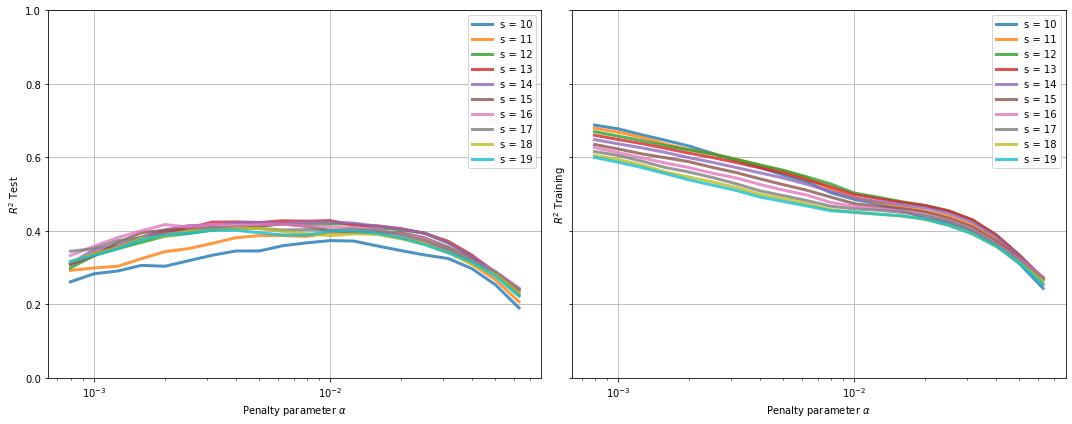

In [4]:
crossval.PlotCVresults()

In [5]:
crossval.ProcessCVresults()[['shiftdays','alpha','R2 Test Weighted', 'R2 Test Avgd']].sort_values('R2 Test Weighted', ascending=False).head(10)

,shiftdays,alpha,R2 Test Weighted,R2 Test Avgd
60,13,0.010000,0.428212,0.425555
77,13,0.006310,0.427772,0.422889
78,13,0.007943,0.426655,0.423681
73,13,0.003981,0.424611,0.415615
80,14,0.010000,0.424547,0.424960
71,13,0.003162,0.423967,0.416923
98,14,0.007943,0.423593,0.422851
75,13,0.005012,0.423109,0.418315
95,14,0.005012,0.423052,0.414485
93,14,0.003981,0.422891,0.414604


In [6]:
crossval.ComputeFinalModels(modelparameters=[(13,1e-2)])

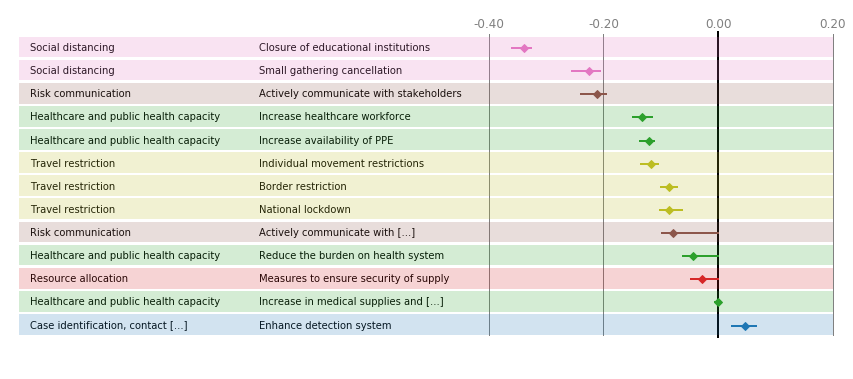

In [7]:
crossval.PlotMeasureListSorted(drop_zeros = True, entryheight=.4, rescale = False, filename='measurelist_200618.pdf', graylines = [-40,-20,20])

In [8]:
crossval.FinalMeasureEffects(additional_columns=['mean','std']).sort_values(['Measure_L1','Measure_L2']).to_csv('measurelist_200618.csv')

In [9]:
# additional statistical tests

crossval_removeAmer = cvc.CrossValidation(**default_params, RemoveContinent = 'Americas')
crossval_removeAsia = cvc.CrossValidation(**default_params, RemoveContinent = 'Asia')
crossval_removeEuro = cvc.CrossValidation(**default_params, RemoveContinent = 'Europe')


In [10]:
crossval_removeAmer.ComputeFinalModels(modelparameters=[(13,1e-2)])
crossval_removeAsia.ComputeFinalModels(modelparameters=[(13,1e-2)])
crossval_removeEuro.ComputeFinalModels(modelparameters=[(13,1e-2)])


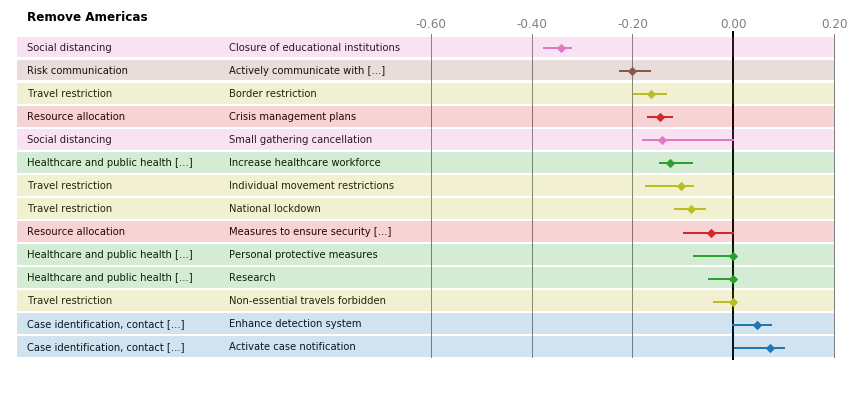

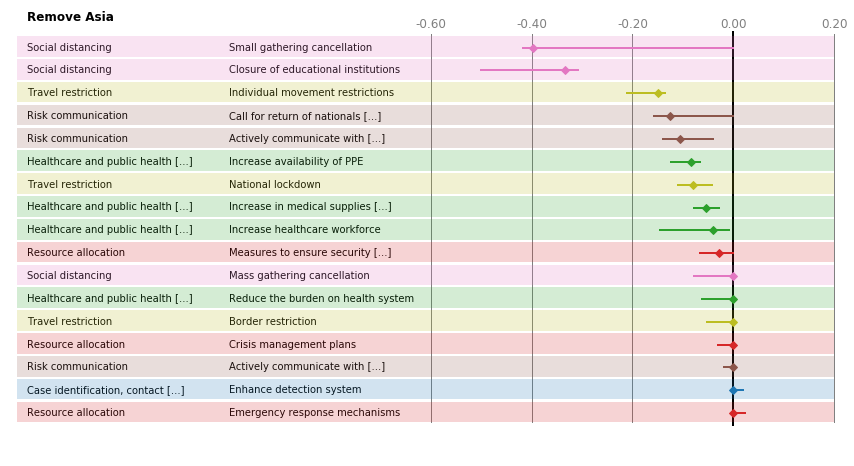

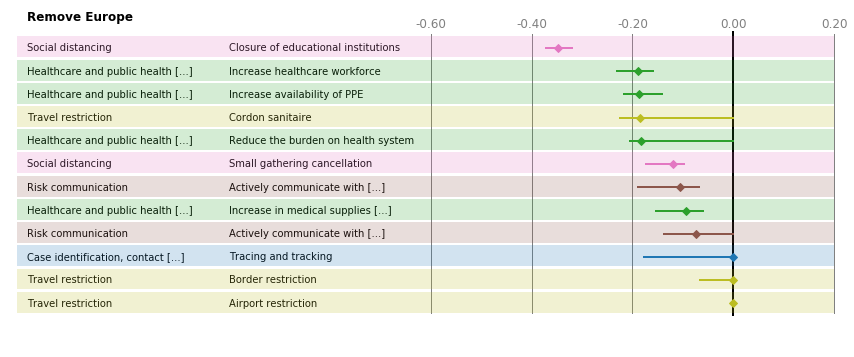

In [11]:
crossval_removeAmer.PlotMeasureListSorted(drop_zeros=True, entryheight=.4, rescale = False, title = 'Remove Americas', graylines = [-60,-40,-20,20], textbreak = 35)
crossval_removeAsia.PlotMeasureListSorted(drop_zeros=True, entryheight=.4, rescale = False, title = 'Remove Asia',     graylines = [-60,-40,-20,20], textbreak = 35)
crossval_removeEuro.PlotMeasureListSorted(drop_zeros=True, entryheight=.4, rescale = False, title = 'Remove Europe',   graylines = [-60,-40,-20,20], textbreak = 35)


In [13]:
crossval_removeAmer.FinalMeasureEffects(additional_columns=['mean','std']).sort_values(['Measure_L1','Measure_L2']).to_csv('measurelist_200618_removeAmer.csv')
crossval_removeAsia.FinalMeasureEffects(additional_columns=['mean','std']).sort_values(['Measure_L1','Measure_L2']).to_csv('measurelist_200618_removeAsia.csv')
crossval_removeEuro.FinalMeasureEffects(additional_columns=['mean','std']).sort_values(['Measure_L1','Measure_L2']).to_csv('measurelist_200618_removeEuro.csv')

In [14]:
# reset CV data
crossval.CVresults = None

# run CV for additional plot
#crossval.RunCV(shiftdaylist = np.arange(22), alphalist = [10**-2.2])

# takes a long time, load from external file
crossval.LoadCVResults('cv_200618_shiftdays.csv')

# loading CV results from "cv_200618_shiftdays.csv"


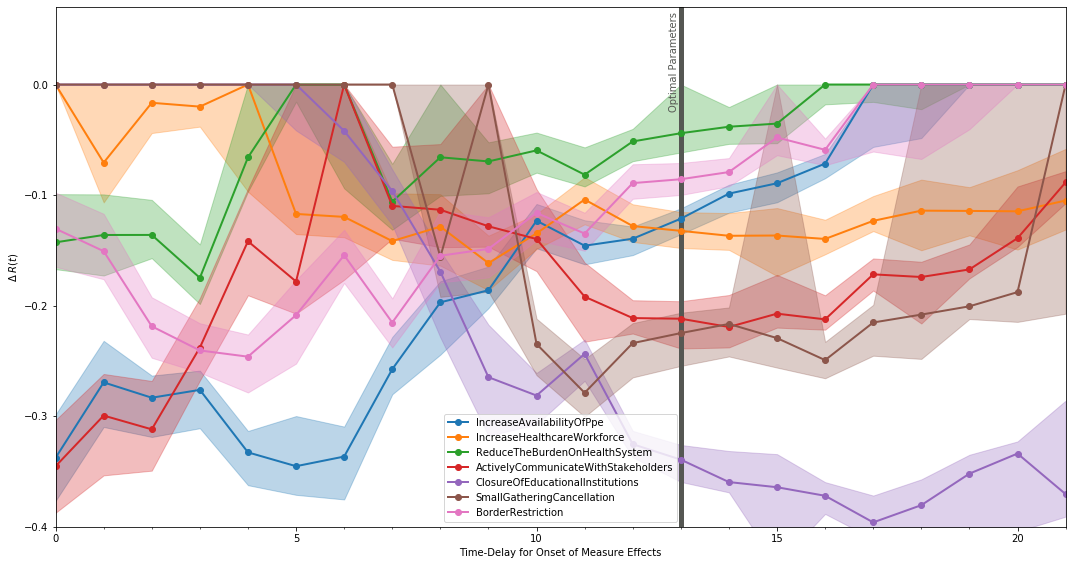

In [15]:
def lasso_median(x):
    return x.quantile(.5)
def lasso_low95(x):
    return x.quantile(.025)
def lasso_high95(x):
    return x.quantile(.975)

measurelist = ['IncreaseAvailabilityOfPpe', 'IncreaseHealthcareWorkforce',
               'ReduceTheBurdenOnHealthSystem','ActivelyCommunicateWithStakeholders', 
               'ClosureOfEducationalInstitutions', 'SmallGatheringCancellation',
               'BorderRestriction'
              ]


measureeffects = crossval.CVresults[['shiftdays'] + measurelist].groupby(by = 'shiftdays').agg([lasso_median,lasso_low95,lasso_high95])
measureeffects.T.to_csv('measureeffects_over_shiftdays_200616.csv')
colornames       = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

fig,ax = plt.subplots(1,1,figsize = (15,8))

for i,measure in enumerate(measurelist):
    ax.plot(measureeffects[(measure,'lasso_median')],label = measure, c = colornames[i], lw = 2, marker = 'o')
    ax.fill_between(measureeffects.index, measureeffects[(measure,'lasso_low95')],measureeffects[(measure,'lasso_high95')], color = colornames[i], alpha = .3 )
ax.set_ylim([-.4,.07])
ax.set_xlim([0,21])
ax.vlines(13,-.4,.1, color = '#555753',lw=5)
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlabel('Time-Delay for Onset of Measure Effects')
ax.set_ylabel(r'$\Delta\; R(t)$')
ax.annotate('Optimal Parameters',(12.75,.02),rotation=90,va='center',c='#555753')
fig.tight_layout()
fig.savefig('measureeffects_over_shiftdays.pdf')

In [16]:
specialcountries = ['US - California', 'US - New York', 'United Kingdom', 'Germany', 'Italy']

crossval.FinalTrajectories(countrylist = specialcountries).T.to_csv('trajectories_200618.csv')

In [17]:
externaldatafile = pd.read_csv('COVID19_data_PAPER_VERSION.csv',sep=';')

for country in specialcountries:
    print(country)
    print(externaldatafile[externaldatafile['Country'] == country][['Date','R','Confirmed']].dropna().head())
    print()

US - California
             Date         R  Confirmed
27151  2020-03-08  2.934459       95.0
27152  2020-03-09  2.680267      101.0
27153  2020-03-10  2.542538      144.0
27154  2020-03-11  2.440592      178.0
27155  2020-03-12  2.364802      221.0

US - New York
             Date         R  Confirmed
36063  2020-03-10  3.471797      150.0
36064  2020-03-11  3.475406      220.0
36065  2020-03-12  3.793604      327.0
36066  2020-03-13  4.308383      421.0
36067  2020-03-14  4.733108      613.0

United Kingdom
             Date         R  Confirmed
37544  2020-03-06  2.845875      164.0
37545  2020-03-07  2.510493      207.0
37546  2020-03-08  2.356919      274.0
37547  2020-03-09  2.349254      322.0
37548  2020-03-10  2.392043      384.0

Germany
            Date         R  Confirmed
7840  2020-03-02  3.744388      159.0
7841  2020-03-03  3.288124      196.0
7842  2020-03-04  2.916635      262.0
7843  2020-03-05  2.643076      482.0
7844  2020-03-06  2.469631      670.0

Italy
       